Reading resources:

https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
    
 https://www.statisticssolutions.com/time-series-analysis/
 
 https://people.stfx.ca/tleo/ECON370Term2Lec5.pdf

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = 15,10


Data available at
https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv

In [2]:
#Load air passengers data
data= pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
#Reread data in the form of dates as index
dateparse = lambda dates: dt.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
#Check if datatype is datetime of the index of the dataframe
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [6]:
#Function to test the stationarity of ts
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df):
    
    #Determing moving statistics
    #Sometimes also known as running or rolling statistics
    #Time period is 12 to signify 12 months of one year
    moving_avg = df.rolling(12).mean()
    moving_std = df.rolling(12).std()

    #Plot the series and statistics
    plt.plot(df, color='blue',label='Original Series')
    plt.plot(moving_avg, color='red', label='Moving average')
    plt.plot(moving_std, color='purple', label = 'Moving Std. deviation')
    plt.legend(loc='best')
    plt.title('Moving average & Standard Deviation')
    plt.show()
    
    #Dickey-Fuller test of stationarity:
    print ('Dickey-Fuller test of stationarity:')
    stationarity_test = adfuller(df, autolag='AIC')
    test_output = pd.Series(stationarity_test[0:4], index=['Test Statistic','p-value','#Lags','Number of Observations'])
    for key,value in stationarity_test[4].items():
        test_output['Critical Value (%s)'%key] = value
    print(test_output)

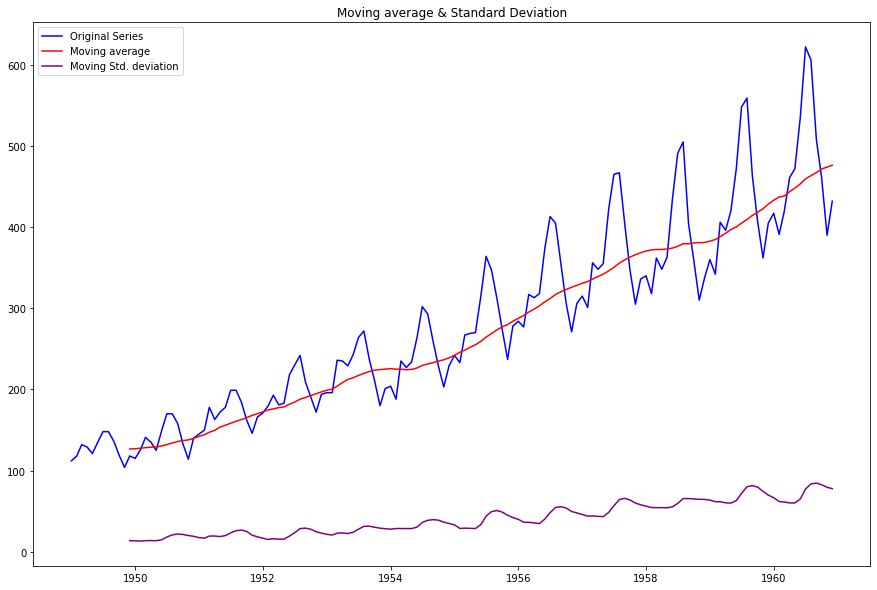

Dickey-Fuller test of stationarity:
Test Statistic              0.815369
p-value                     0.991880
#Lags                      13.000000
Number of Observations    130.000000
Critical Value (1%)        -3.481682
Critical Value (5%)        -2.884042
Critical Value (10%)       -2.578770
dtype: float64


In [7]:
test_stationarity(data)

p-value tells us that the timeseries in question is not stationary. Stationarity is the first assumtion in any time series problem. 

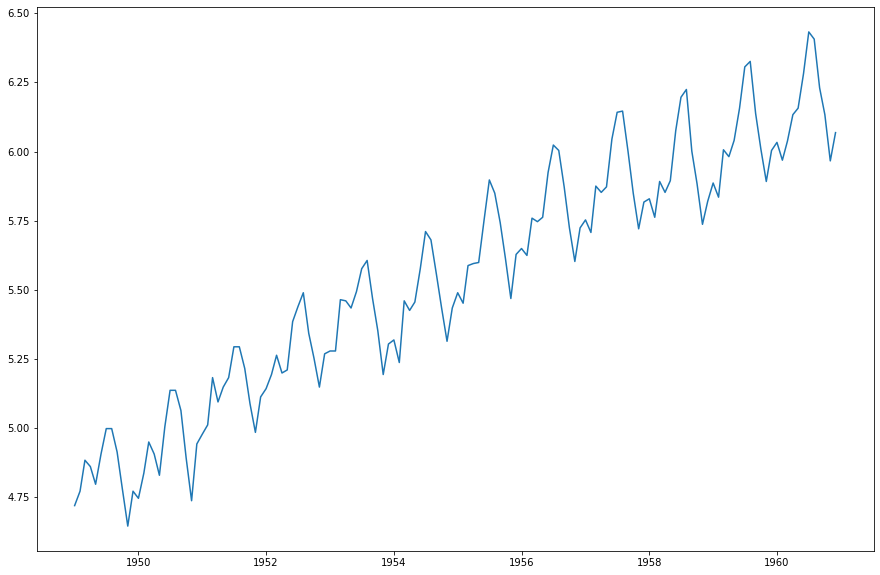

In [8]:

data_log = np.log(data)
#data_log = np.sqrt(data)
#data_log = np.cbrt(data)
plt.plot(data_log)
plt.show()

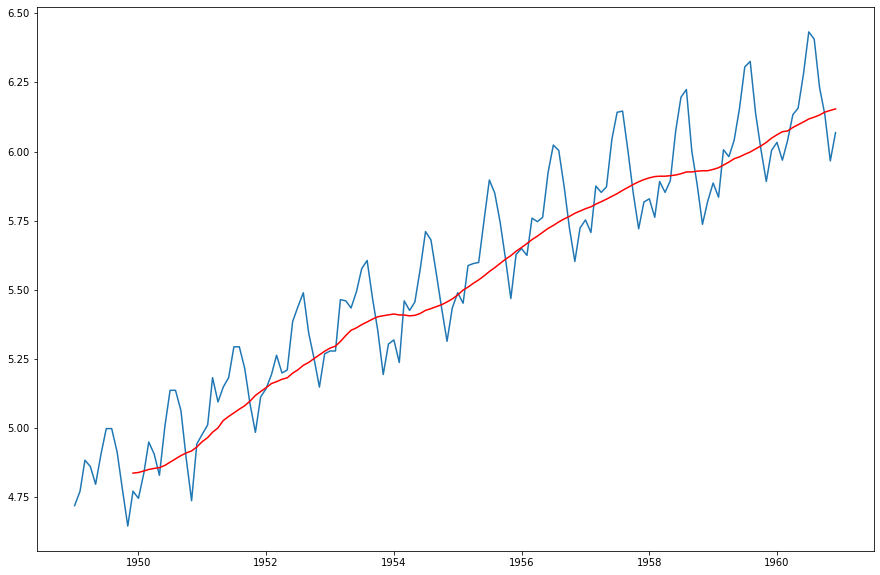

In [9]:
moving_avg = data_log.rolling(12).mean()
plt.plot(data_log)
plt.plot(moving_avg, color='red')
plt.show()

In [10]:
data_log_moving_avg_diff =data_log - moving_avg
data_log_moving_avg_diff.head(14)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


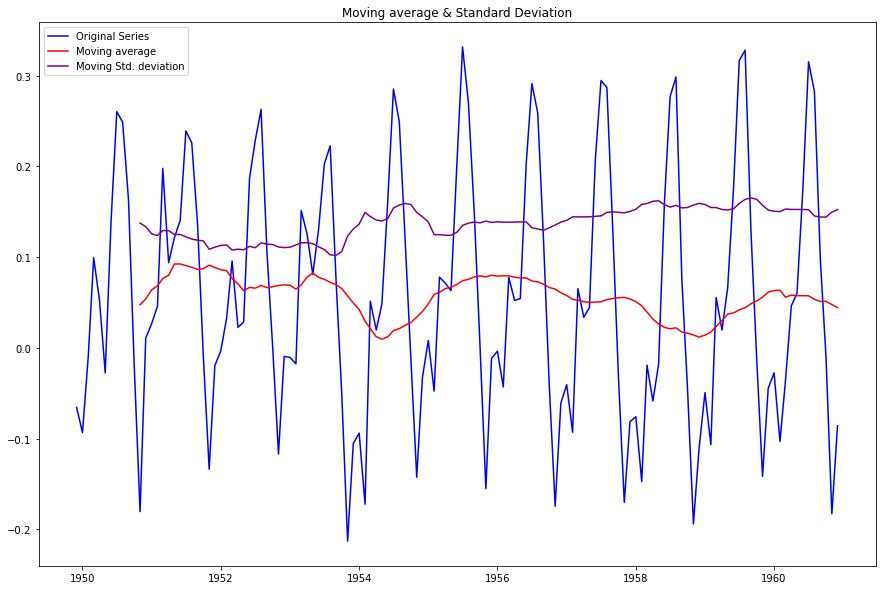

Dickey-Fuller test of stationarity:
Test Statistic             -3.162908
p-value                     0.022235
#Lags                      13.000000
Number of Observations    119.000000
Critical Value (1%)        -3.486535
Critical Value (5%)        -2.886151
Critical Value (10%)       -2.579896
dtype: float64


In [11]:
data_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(data_log_moving_avg_diff)

## Eliminating Trend and Seasonality
The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

Differencing – taking the differece with a particular time lag


Decomposition – modeling both trend and seasonality and removing them from the model.

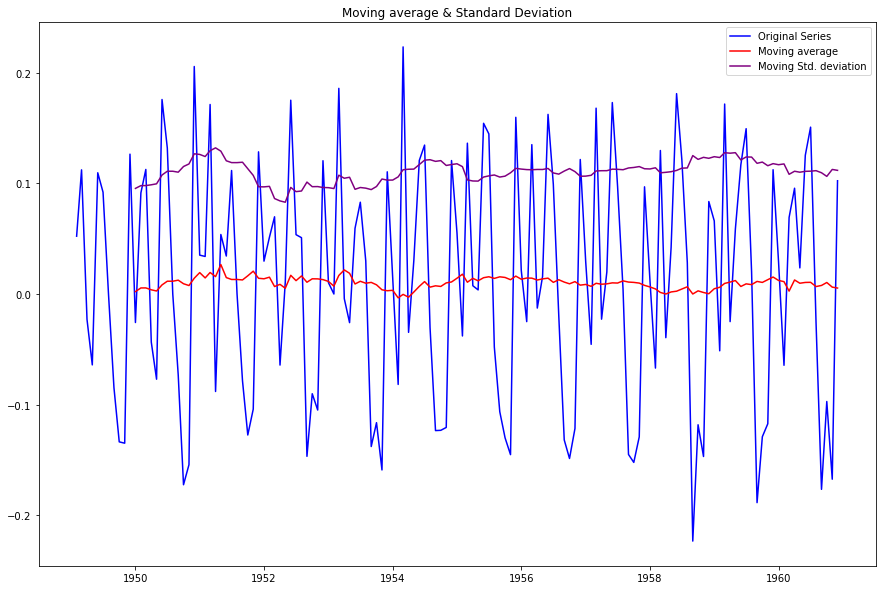

Dickey-Fuller test of stationarity:
Test Statistic             -2.717131
p-value                     0.071121
#Lags                      14.000000
Number of Observations    128.000000
Critical Value (1%)        -3.482501
Critical Value (5%)        -2.884398
Critical Value (10%)       -2.578960
dtype: float64


In [12]:
#Differencing first order
data_log_diff = data_log - data_log.shift()
data_log_diff.dropna(inplace=True)
test_stationarity(data_log_diff)

The test statistic is significant at .1 critical value. We can try second order differencing to see if it improves the time series.

Calculating the second order differencing of a time series is useful for converting a non stationary time series to a stationary form. It is calculated as follows. 

The i-th data point Y_i of a time series is replaced by 

$Y'_i = Y_i - [2 * Y_{(i-1)}] + Y_{(i-2)}$

Proof:

$ Y'_i  =  \Delta^2 Y_i = \Delta ( \Delta Y_i) $

$ => Y'_i  = \Delta (Y_i -  Y_{(i-1)})$

$ => Y'_i  = \Delta Y_i - \Delta Y_{(i-1)} $

$ => Y'_i  =  (Y_i - Y_{(i-1)})  - ( Y_{(i-1)} - Y_{(i-2)}) $

$ => Y'_i  =  Y_i - 2Y_{(i-1)} + Y_{(i-2)} $




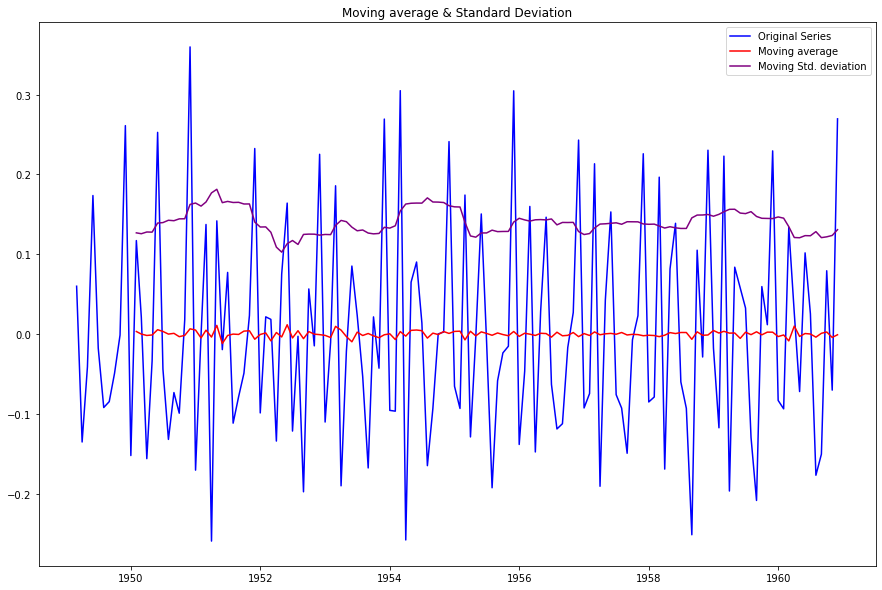

Dickey-Fuller test of stationarity:
Test Statistic           -8.196629e+00
p-value                   7.419305e-13
#Lags                     1.300000e+01
Number of Observations    1.280000e+02
Critical Value (1%)      -3.482501e+00
Critical Value (5%)      -2.884398e+00
Critical Value (10%)     -2.578960e+00
dtype: float64


In [13]:
#Second order differencing
#Differencing
data_log_diff_1 = data_log.shift()
data_log_diff_2 = data_log_diff_1.shift()

data_log_diff = data_log - ( 2* data_log_diff_1) + data_log_diff_2
data_log_diff.dropna(inplace=True)
test_stationarity(data_log_diff)

Looks good. Let's still try decomposing next.

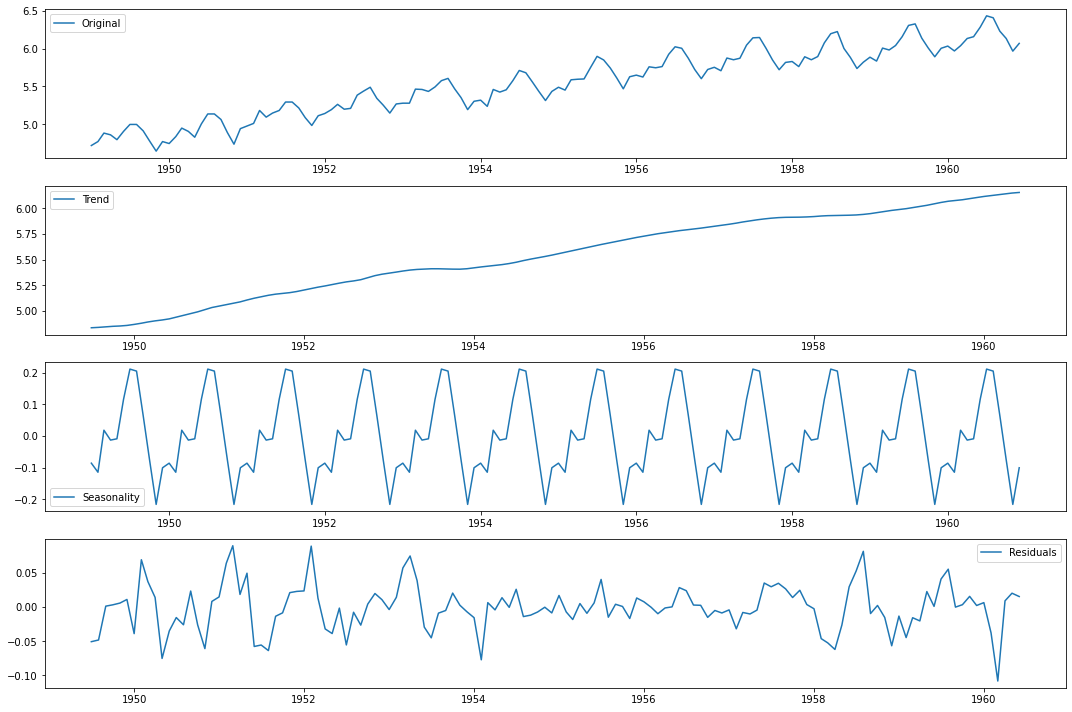

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

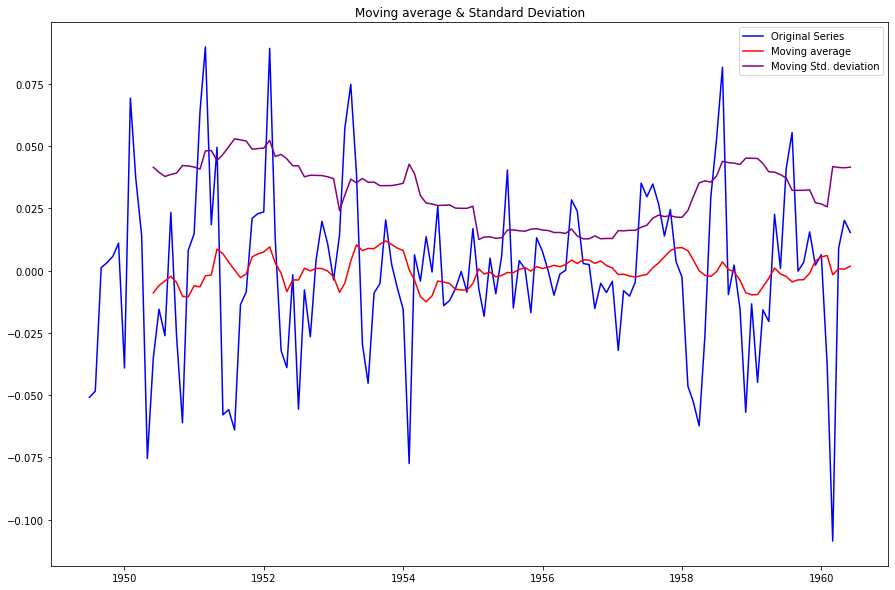

Dickey-Fuller test of stationarity:
Test Statistic           -6.332387e+00
p-value                   2.885059e-08
#Lags                     9.000000e+00
Number of Observations    1.220000e+02
Critical Value (1%)      -3.485122e+00
Critical Value (5%)      -2.885538e+00
Critical Value (10%)     -2.579569e+00
dtype: float64


In [15]:
data_log_decompose = residual
data_log_decompose.dropna(inplace=True)
test_stationarity(data_log_decompose)

# Forecasting

In [16]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [17]:
lag_acf = acf(data_log_diff, nlags=20)
lag_pacf = pacf(data_log_diff, nlags=20, method='ols')

C:\Users\Manish\Miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


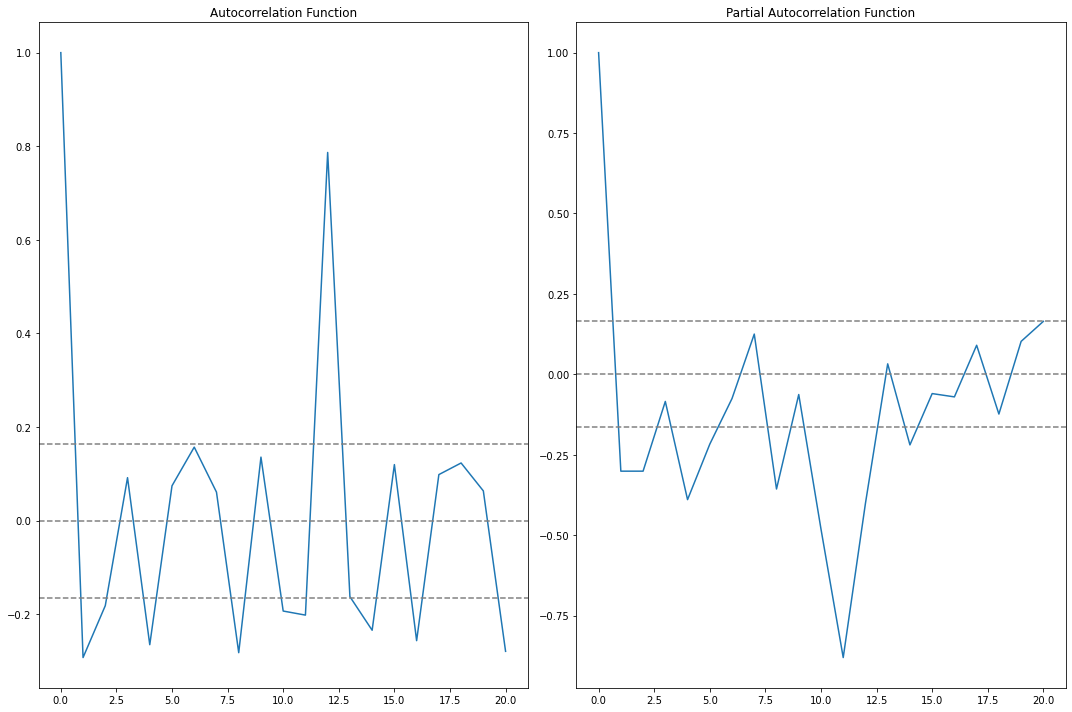

In [18]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [19]:
from statsmodels.tsa.arima_model import ARIMA


C:\Users\Manish\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Manish\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Residual sum of squares, RSS: 3.1110')

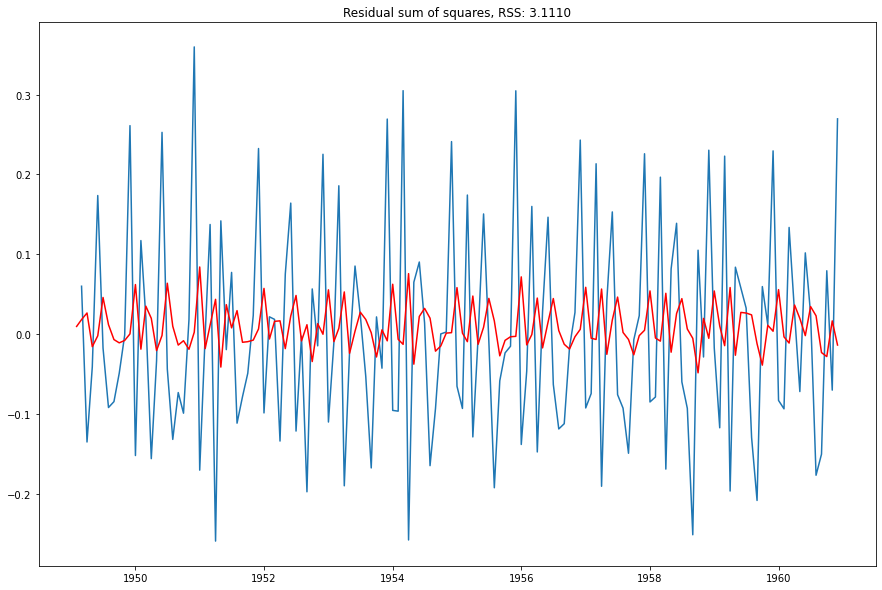

In [20]:
model = ARIMA(data_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(data_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('Residual sum of squares, RSS: %.4f'% np.sum(((results_AR.fittedvalues) - data_log_diff.iloc[:,0])**2))

C:\Users\Manish\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Manish\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Residual sum of squares, RSS: 2.7827')

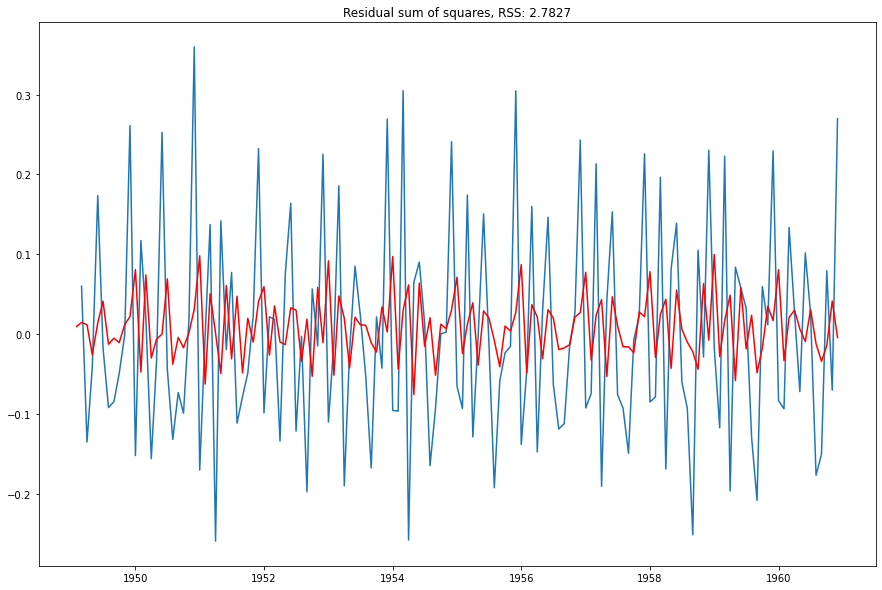

In [21]:
model = ARIMA(data_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(data_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Residual sum of squares, RSS: %.4f'% np.sum(((results_MA.fittedvalues) - data_log_diff.iloc[:,0])**2))

C:\Users\Manish\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Manish\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Residual sum of squares, RSS: 2.6180')

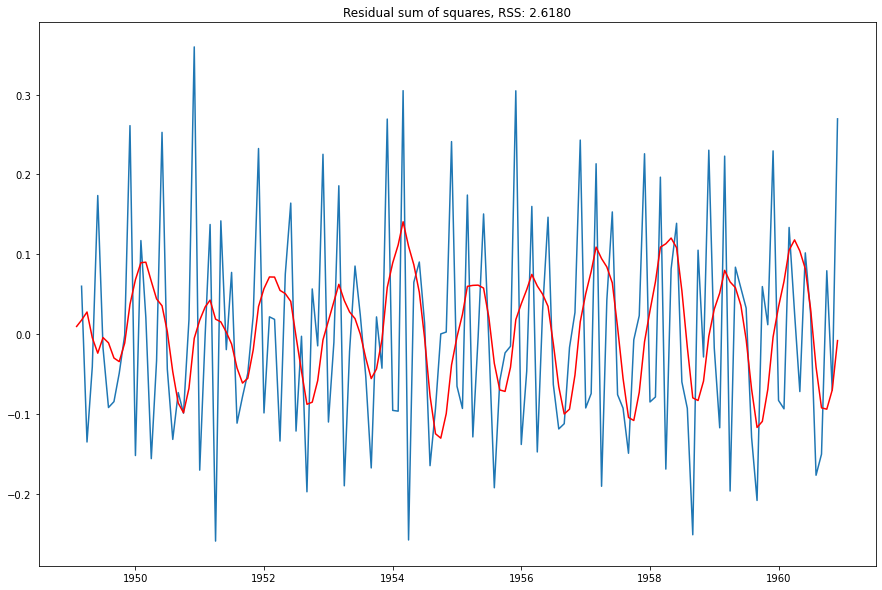

In [22]:
model = ARIMA(data_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(data_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Residual sum of squares, RSS: %.4f'% np.sum(((results_ARIMA.fittedvalues) - data_log_diff.iloc[:,0])**2))

In [23]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [24]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [25]:
predictions_ARIMA_log = pd.Series(data_log.iloc[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01         NaN
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
dtype: float64

Text(0.5, 1.0, 'RMSE: 302.6140')

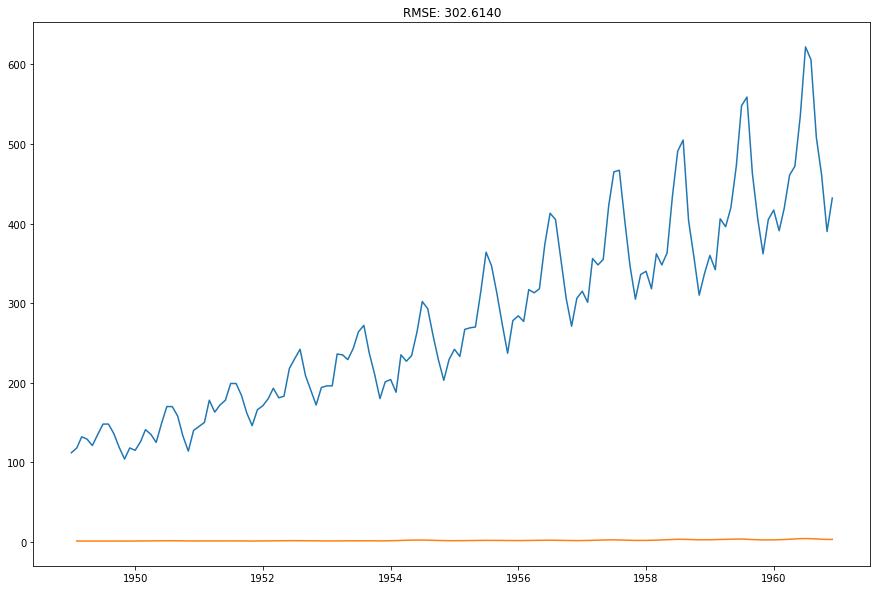

In [26]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))
plt.title('RMSE: %.4f'% np.sqrt((np.sum((predictions_ARIMA - data.iloc[:,0])**2))/len(data)))